# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

## Word2vec

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.16


Agora vamos estudar na prática o Word2vec, uma técnica usada para aprender word embeddings ou distribuição numérica de representações de features de palavras. Aprender essas representações é uma das atividades fundamentais no PLN moderno, pois PLN precisa de boas representações de palavras que preservam a semântica, assim como o contexto da linguagem. Por exemplo: a representação de features da palavra floresta deve ser bem diferente da palavra geladeira, pois essas palavras raramente aparecem juntas em um texto, enquanto as representações das palavras floresta e selva devem ser bem similares!

Word2vec é chamado de "representação distribuída" uma vez que a semântica da palavra é capturada pelo padrão de ativação da representação completa do vetor. Word2vec aprende o significado de uma dada palavra analisando seu contexto e representando-o de forma numérica. Contexto aqui significa um número fixo de palavras antes e depois da palavra de interesse.

Iremos passo a passo para que você compreenda como funciona todo o processo. 

** ATENÇÃO **: Esse código pode consumir uma quantidade significativa de memória. Se você tiver mais de 4GB de memória RAM, não precisa se preocupar. Caso contrário, reduza o parâmetro `batch_size` ou `embedding_size` para permitir que o modelo caiba na memória. Outra opção, é executar no Titan.

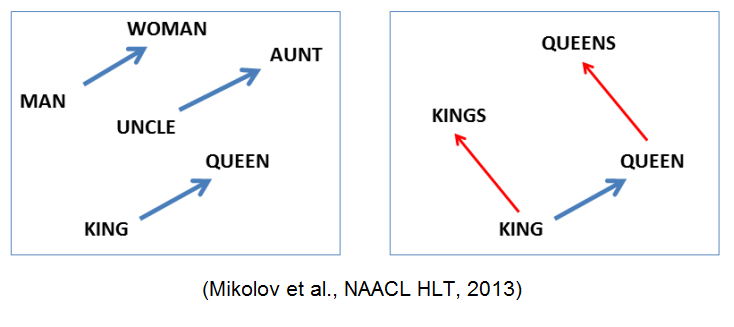

In [2]:
from IPython.display import Image
Image("images/word2vec.png")

Word2vec é um conjunto formado por dois modelos:

- Skip-gram
- Continuous Bag-of-Words (CBOW)

Tarefa: Aprender de modo eficiente uma representação vetorial de palavras a partir de um corpus grande e não-estruturado. Esse aprendizado é feito atraves das estatísticas de co-ocorrência das palavras em algum corpus. 

Dado um corpus, escolhemos:

- Um vocabulário V.
- Um tamanho N para a representação vetorial das palavras.

Vamos usar duas matrizes, uma para representar o input vector e outra para o output vector. A tarefa do modelo vai ser prever uma palavra de centro dada uma palavra de contexto. Por exemplo:

O primeiro rei de Portugal nasceu em ...

- Observação => (rei, primeiro)
- Observacao => (input word, output word)
- Observacao => (wI , wo)

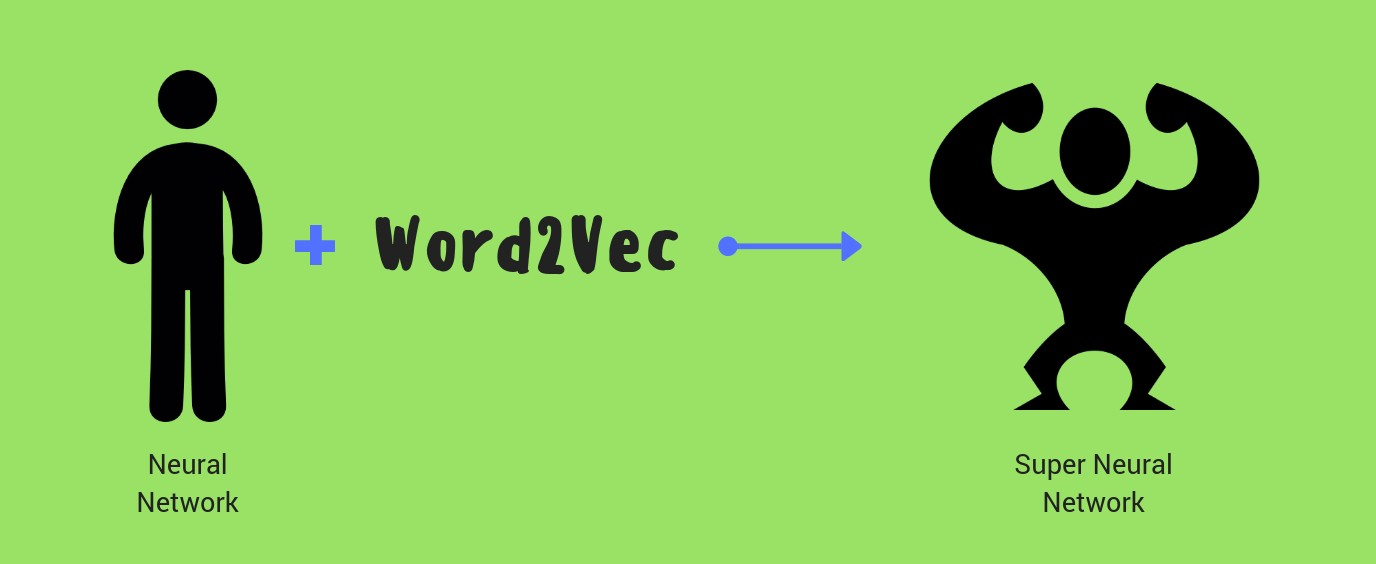

In [3]:
from IPython.display import Image
Image("images/superneural.jpeg")

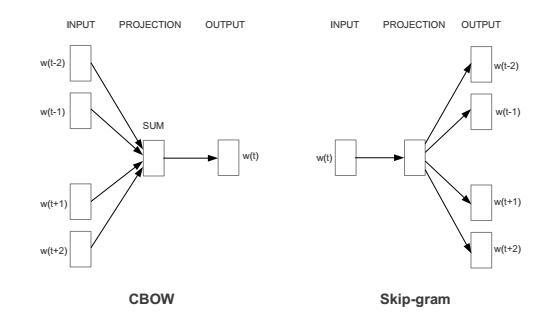

In [4]:
from IPython.display import Image
Image("images/cbowskip.png")

In [5]:
!nvidia-smi

Tue Apr  4 09:33:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.07    Driver Version: 527.27       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P2200        On   | 00000000:01:00.0  On |                  N/A |
| 55%   51C    P0    22W /  75W |   1188MiB /  5120MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

In [7]:
# Imports
import os
import csv
import collections
import math
import random
import bz2
import nltk
import operator
import numpy as np
import tensorflow as tf
import matplotlib
import sklearn
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from math import ceil

# As novas versões do Pandas e Matplotlib trazem diversas mensagens de aviso ao desenvolvedor. Vamos desativar isso.
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

2023-04-04 09:33:55.356171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Se necessário, faça o download dos pacotes do NLTK. Digite all quando for solicitado o nome do pacote.
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [10]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
matplotlib: 3.3.2
nltk      : 3.8.1
tensorflow: 2.11.1
sklearn   : 1.2.2
numpy     : 1.24.2
csv       : 1.0



In [11]:
# Obs: Este script está compatível com as versões 1.x e 2.x do TensorFlow.
# Optamos por manter assim, pois alguns recursos avançados usados neste script ainda não foram implementados no TF 2.

# Para executar este script com TF 2, nenhum passo adicional precisa ser feito.
# Para executar com TF 1, remova o prefixo tf.compat.v1 ao longo do scriipt e substitua por tf, e comente as 3 linhas abaixo.
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

## Dataset
Este código faz o download de um [conjunto de dados] (http://www.evanjones.ca/software/wikipedia2text.html) que consiste em vários artigos da Wikipedia, totalizando aproximadamente 61 MB. Além disso, o código garante que o arquivo tenha o tamanho correto após o download.

In [12]:
# Download do dataset
url = 'http://www.evanjones.ca/software/'

def maybe_download(filename, expected_bytes):
    """Faz o download de um arquivo, se não estiver presente, e verifica se ele está no tamanho certo."""
    if not os.path.exists(filename):
        print('Fazendo o download...')
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)

    if statinfo.st_size == expected_bytes:
        print('Encontrado e verificado: %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception('Não foi possível verificar ' + filename + '. Você consegue fazer o download com um navegador?')
    return filename

filename = 'dados/wikipedia2text-extracted.txt.bz2'

## Lendo os dados sem pré-processamento 
Leitura dos dados como string, tokeniza usando espaços e retorna uma lista de palavras.

In [13]:
def read_data(filename):
    """Extrai o primeiro arquivo contido no arquivo zip como uma lista de palavras"""

    with bz2.BZ2File(filename) as f:
        data = []
        file_string = f.read().decode('utf-8')
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
    return data

words = read_data(filename)
print('Número de palavras no dataset %d' % len(words))
print('Palavras de exemplo (start): ',words[:10])
print('Palavras de exemplo (end): ',words[-10:])

Número de palavras no dataset 11634771
Palavras de exemplo (start):  ['Propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Palavras de exemplo (end):  ['useless', 'for', 'cultivation', '.', 'and', 'people', 'have', 'sex', 'there', '.']


## Lendo os dados sem pré-processamento usando NLTK
Leitura dos dados como string, converte em minúscula e converte em tokens usando a biblioteca nltk. Esse código lê os dados em partes de 1 MB, pois o processamento do texto completo seria muito lento, e então retorna uma lista de palavras. Você terá que baixar o tokenizer necessário.

In [14]:
def read_data(filename):
  """
  Extrai o primeiro arquivo contido em um arquivo zip como uma lista de palavras
  e pré-processa usando a biblioteca nltk python
  """

  with bz2.BZ2File(filename) as f:

    data = []
    file_size = os.stat(filename).st_size
    chunk_size = 1024 * 1024 # lendo 1 MB de cada vez, pois o conjunto de dados é moderadamente grande
    print('Lendo os dados...')
    for i in range(ceil(file_size//chunk_size)+1):
        bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
        file_string = f.read(bytes_to_read).decode('utf-8')
        file_string = file_string.lower()

        # tokeniza uma string para palavras que residem em uma lista
        file_string = nltk.word_tokenize(file_string)
        data.extend(file_string)
    return data

words = read_data(filename)
print('Número de palavras no dataset %d' % len(words))
print('Palavras de exemplo (start): ',words[:10])
print('Palavras de exemplo (end): ',words[-10:])

Lendo os dados...
Número de palavras no dataset 3361199
Palavras de exemplo (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Palavras de exemplo (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']


## Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Também introduzimos um token especial adicional chamado `UNK` para indicar que palavras raras são muito raras para serem usadas.

In [15]:
# Nós restringimos o tamanho do nosso vocabulário para 50000
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]

    # Obtém apenas o vocabulary_size para palavras mais comuns como o vocabulário
    # Todas as outras palavras serão substituídas por token UNK
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()

    # Cria um ID para cada palavra, dando o comprimento atual do dicionário
    # e adicionando esse item ao dicionário
    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0

    # Percorrer todo o texto que temos e produzir uma lista onde cada elemento corresponde ao ID
    # da palavra encontrada nesse índice
    for word in words:
        # Se a palavra estiver no dicionário, use a palavra ID, senão use o ID do token especial "UNK"
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)

    # Atualiza a variável count com o número de ocorrências UNK
    count[0][1] = unk_count

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    # Verifica se o dicionário é do tamanho do vocabulário
    assert len(dictionary) == vocabulary_size

    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Palavras mais comuns (+UNK)', count[:5])
print('Dados de amostra', data[:10])
del words

Palavras mais comuns (+UNK) [['UNK', 68741], ('the', 226895), (',', 184013), ('.', 120913), ('of', 116323)]
Dados de amostra [1721, 9, 8, 16479, 223, 4, 5168, 4459, 26, 11597]


## Gerando Lotes de Dados para o Skip-Gram
Gera um lote ou palavras de destino (`batch`) e um lote de palavras de contexto correspondentes (`labels`). Ele lê as palavras `2 * window_size + 1` por vez (chamado` span`) e cria os datapoints `2 * window_size` em um único intervalo. A função continua dessa maneira até que os datapoints `batch_size` sejam criados. Toda vez que chegamos ao final da sequência de palavras, retornamos ao começo.

In [16]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
    # data_index é atualizado por 1 toda vez que lemos um ponto de dados
    global data_index

    # Dois arrays para conter as palavras-alvo (lote) e as palavras de contexto (etiquetas)
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    # span define o tamanho total da janela, onde os dados que consideramos em uma instância
    # são exibidos da seguinte maneira: [skip_window target skip_window]
    span = 2 * window_size + 1

    # O buffer contém os dados contidos no intervalo
    buffer = collections.deque(maxlen=span)

    # Preenche o buffer e atualiza o data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Este é o número de palavras de contexto que experimentamos para uma única palavra de destino
    num_samples = 2 * window_size

    # Nós dividimos a leitura do lote em dois loops for
    # O loop interno preenche o lote e os rótulos com
    # num_samples pontos de dados usando dados contidos no intervalo
    # O loop externo é repetido por batch_size // num_samples times
    # para produzir um lote completo
    for i in range(batch_size // num_samples):
        k=0

        # Evita a própria palavra alvo como uma previsão
        # Preenchimento de matrizes de lotes e rótulos numpy
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1

        # Toda vez que lemos num_samples pontos de dados,
        # criamos o número máximo de pontos de dados possíveis
        # com um único intervalo, por isso precisamos mover o span por 1
        # para criar um novo intervalo
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('Dados:', [reverse_dictionary[di] for di in data[:8]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nCom window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

Dados: ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed']

Com window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'concerted', 'concerted', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'concerted', 'a', 'set', 'concerted', 'of']

Com window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'concerted', 'concerted', 'concerted', 'concerted']
    labels: ['propaganda', 'is', 'concerted', 'set', 'is', 'a', 'set', 'of']


## Algoritmo Skip-Gram 

Com esse algoritmo vamos tentar prever o contexto dado a palavra de centro.

- Observação =>  (wI , [wO1 , . . . ,wOC ])
- Resultado => (cantor, [com, o, dessa, banda])

Nesse modelo queremos minimizar a soma da entropia cruzada que é o mesmo que maximizar p(wo1 , . . . ,woC | wI ).

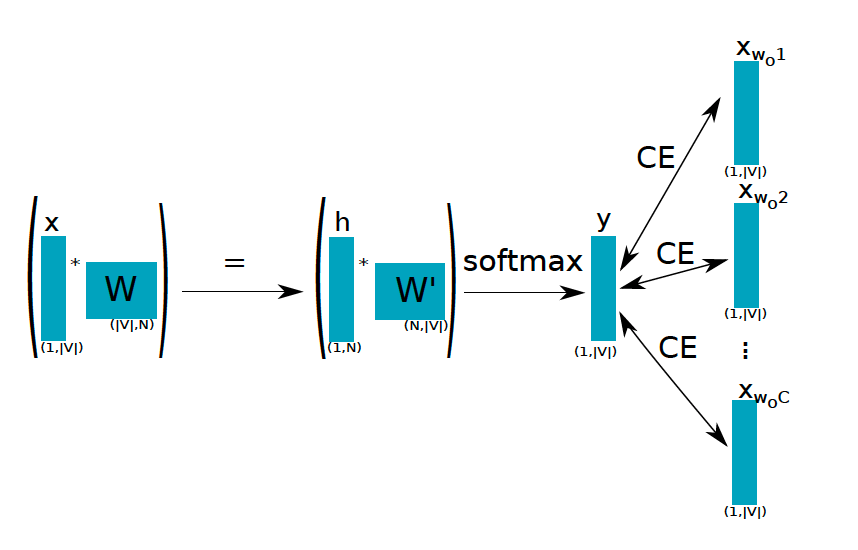

In [17]:
from IPython.display import Image
Image("images/skip.png")

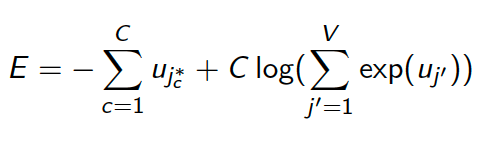

In [18]:
from IPython.display import Image
Image("images/erro-skip.png")

### Definindo Hiperparâmetros

Aqui nós definimos vários hiperparâmetros incluindo 

- `batch_size` (quantidade de amostras em um único lote) 
- `embedding_size` (tamanho dos embedding vectors) 
- `window_size` (tamanho da janela de contexto).

In [19]:
# Pontos de dados em um único lote
batch_size = 128

# Dimensão do embedding vector.
embedding_size = 128

# Quantas palavras considerar à esquerda e à direita.
window_size = 4

# Nós escolhemos um conjunto de validação aleatório para testar os vizinhos mais próximos
# Conjunto aleatório de palavras para avaliar a similaridade.
valid_size = 16

# Nós experimentamos datapoints válidos aleatoriamente a partir de uma janela grande sem sermos sempre determinísticos
valid_window = 50

# Ao selecionar exemplos válidos, selecionamos algumas das palavras mais frequentes,
# bem como algumas palavras moderadamente raras
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

# Número de exemplos negativos para amostra.
num_sampled = 32

### Definindo Entradas e Saídas

Aqui nós definimos espaços reservados (placeholders) para alimentação dos dados de entrada e saída para o treinamento (cada um de tamanho `batch_size`) e um tensor constante para conter exemplos de validação.

In [20]:
tf.compat.v1.reset_default_graph()

# Dados de entrada de treinamento (IDs de palavras de destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size])

# Dados de etiqueta de entrada de treinamento (IDs de palavras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

# Dados de entrada de validação, não precisamos de um espaço reservado,
# pois já definimos os IDs das palavras selecionadas como dados de validação
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos diversas variáveis do TensorFlow, como uma camada embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [21]:
# Variáveis

# Embedding layer, contém as word embeddings
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# Softmax Weights e Biases
softmax_weights = tf.Variable(
    tf.random.truncated_normal([vocabulary_size, embedding_size],
                        stddev=0.5 / math.sqrt(embedding_size)))

softmax_biases = tf.Variable(tf.random.uniform([vocabulary_size],0.0,0.01))

### Definindo as Computações do Modelo

Primeiro, definimos uma função de pesquisa para buscar os vetores embeddings correspondentes para um conjunto de entradas fornecidas. Com isso, definimos a função de perda negativa de amostragem `tf.nn.sampled_softmax_loss` que inclui os vetores embeddings e os parâmetros de rede neural previamente definidos.

In [22]:
# Modelo

# Procure por um lote de embeddings.
embed = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset)

# Calcule a perda do softmax usando uma amostra dos rótulos negativos de cada vez.
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(
        weights = softmax_weights, biases = softmax_biases, inputs = embed,
        labels = train_labels, num_sampled = num_sampled, num_classes = vocabulary_size)
)

### Calculando Similaridade de palavras
Calculamos a similaridade entre duas palavras dadas em termos da distância do cosseno. Para fazer isso de maneira eficiente, usamos operações de matriz para fazer isso, conforme mostrado abaixo.

In [23]:
# Calcula a similaridade entre os exemplos de minibatch e todos os embeddings.
# Nós usamos a distância do cosseno:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

### Otimizador de Parâmetros do Modelo

Em seguida, definimos uma taxa de aprendizado constante e um otimizador que usa o método Adagrad. Sinta-se à vontade para experimentar outros otimizadores listados [aqui] (https://www.tensorflow.org/api_guides/python/train).

In [24]:
# Otimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

## Treinando o Algoritmo Skip-Gram

In [25]:
num_steps = 100001
skip_losses = []

# ConfigProto é uma maneira de fornecer várias configurações necessárias para executar o grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

    # Inicializa as variáveis no grafo
    tf.compat.v1.global_variables_initializer().run()
    print('Variáveis Inicializadas')
    average_loss = 0

    # Treina o modelo Word2vec para iterações num_step
    for step in range(num_steps):

        # Gera um único lote de dados
        batch_data, batch_labels = generate_batch_skip_gram(batch_size, window_size)

        # Preenche o feed_dict, executa o otimizador (minimize loss) e calcule a perda
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Atualiza a variável de perda média
        average_loss += l

        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000

            skip_losses.append(average_loss)

            # A perda média é uma estimativa da perda nos últimos 2000 lotes.
            print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
            average_loss = 0

        # Avaliação de simlaridade de palavras do conjunto de validação
        if (step+1) % 10000 == 0:
            sim = similarity.eval()

            # Aqui nós calculamos as palavras top_k mais próximas para uma dada palavra de validação
            # em termos da distância cosseno. Fazemos isso para todas as palavras no conjunto de validação.
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]

                # Número de vizinhos mais próximos
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Mais Próximo da palavra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    skip_gram_final_embeddings = normalized_embeddings.eval()

# Vamos salvar os vetores de palavras aprendidos e a perda ao longo do tempo,
# pois essas informações são necessárias mais tarde para comparações
np.save('resultado/ski-pgram_embeddings', skip_gram_final_embeddings)

with open('resultado/skip-gram_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_losses)

2023-04-04 11:19:10.443791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 11:19:11.043868: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:19:12.194910: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:19:12.195027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/000

Variáveis Inicializadas
Erro Médio no Passo 2000: 3.997454
Erro Médio no Passo 4000: 3.618699
Erro Médio no Passo 6000: 3.586044
Erro Médio no Passo 8000: 3.519723
Erro Médio no Passo 10000: 3.489583
Mais Próximo da palavra .: ,, the, in, 5.4, and, trojan, salica, protest,
Mais Próximo da palavra ;: rehearse, cincinnati, grodno, :, autumns, restriction, cartier, toyota,
Mais Próximo da palavra to: eyesight, for, murnau, 65,000,000, moderns, as, humorous, levy,
Mais Próximo da palavra are: is, immersing, sigur, saparmurat, plesiosaur, have, clodius, tuesday,
Mais Próximo da palavra at: greased, ladysmith, ae, hozier, differing, 2.71, humane, plateaux,
Mais Próximo da palavra ``: sese, wct, henley, oatmeal, realizability, qing, mat, propagandistic,
Mais Próximo da palavra by: for, 36m, vowing, hermetic, with, khalīfa, contour, intercepting,
Mais Próximo da palavra first: marqués, woodworking, 622, dispatcher, concentrations, motley, bourgeoisie, activity,
Mais Próximo da palavra as: bent

Erro Médio no Passo 52000: 3.296837
Erro Médio no Passo 54000: 3.298879
Erro Médio no Passo 56000: 3.312340
Erro Médio no Passo 58000: 3.306628
Erro Médio no Passo 60000: 3.305644
Mais Próximo da palavra .: ,, ;, in, and, the, :, of, chinese,
Mais Próximo da palavra ;: ., :, ,, taught, but, weld, guillermo, downfall,
Mais Próximo da palavra to: erudite, and, navel, bidding, expert, unauthorized, wavell, ,,
Mais Próximo da palavra are: were, okello, is, other, 57th, exhaustion, many, mestská,
Mais Próximo da palavra at: during, 82nd, 1515, deflection, pairing, before, o'keefe, mor,
Mais Próximo da palavra ``: '', psychedelic-era, stylistically, i, relentlessly, UNK, pearse, bombaim,
Mais Próximo da palavra by: tomislav, 210, that, t-80, only, youderian, public-private, lambeth,
Mais Próximo da palavra first: w/m², 's, last, solid-state, during, inlet, lysosomes, annexation,
Mais Próximo da palavra as: eaton, metropolitana, voivodship, vinson, reactivate, ponds, known, glittering,
Mais P

## Visualizando o Aprendizado do Algoritmo Skip-Gram

### Encontrando apenas as palavras agrupadas 

In [26]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    '''
    Encontra apenas os agrupamentos próximos.
    Isso elimina os embeddings de palavra mais esparsamente distribuídos e torna a visualização mais clara.
    Isso é útil para a visualização de t-SNE.

    distance_threshold: distância máxima entre dois pontos para se qualificar como vizinhos
    sample_threshold: número de vizinhos requeridos para serem considerados um cluster
    '''

    # Calcular a similaridade de cosseno
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm

    # Faz todas as entradas na diagonal zero; caso contrário, isso será escolhido como maior
    np.fill_diagonal(cosine_sim, -1.0)

    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim

    # Encontra os máximos em um loop para contar se houver mais de n itens acima do limite
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1

    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

### Computando a Visualização t-SNE de Word Embeddings Usando o Scikit-Learn

t-Distributed Stochastic Neighbor Embedding (t-SNE) é uma técnica (ganhadora de prêmios) para redução de dimensionalidade que é particularmente adequada para a visualização de conjuntos de dados de alta dimensão. A técnica pode ser implementada via aproximações do Barnes-Hut, permitindo que ela seja aplicada em grandes conjuntos de dados do mundo real. 

O t-SNE é uma ferramenta para visualizar dados de alta dimensão. Converte semelhanças entre pontos de dados para probabilidades conjuntas e tenta minimizar a divergência de Kullback-Leibler entre as probabilidades conjuntas da incorporação de baixa dimensão e os dados de alta dimensão. O t-SNE tem uma função de custo que não é convexa, ou seja, com diferentes inicializações, podemos obter resultados diferentes.

É altamente recomendado usar outro método de redução de dimensionalidade (por exemplo, PCA para dados densos ou TruncatedSVD para dados esparsos) para reduzir o número de dimensões para uma quantidade razoável (por exemplo, 50) se o número de características for muito alto.

In [27]:
# Usaremos um grande espaço de amostra para construir o manfold T-SNE e, em seguida, 
# podá-lo usando semelhança de cosseno
num_points = 1000
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
print('Fitting embeddings no T-SNE. Isso pode levar um tempo ...')

# Obtém o T-SNE manifold
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings = tsne.fit_transform(selected_embeddings)

# Poda os embeddings, obtendo apenas mais de n-muitos exemplos acima do limiar de similaridade
# Isto desobstrui a visualização
print('Pruning os T-SNE embeddings')
selected_ids = find_clustered_embeddings(selected_embeddings,.25,10)
two_d_embeddings = two_d_embeddings[selected_ids,:]

print('De um total de ', num_points, ' amostras, ', selected_ids.shape[0],' amostras foram selecionadas para pruning')

Fitting embeddings no T-SNE. Isso pode levar um tempo ...
Pruning os T-SNE embeddings
De um total de  1000  amostras,  393  amostras foram selecionadas para pruning


### Plotar os Resultados do t-SNE com o Matplotlib

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


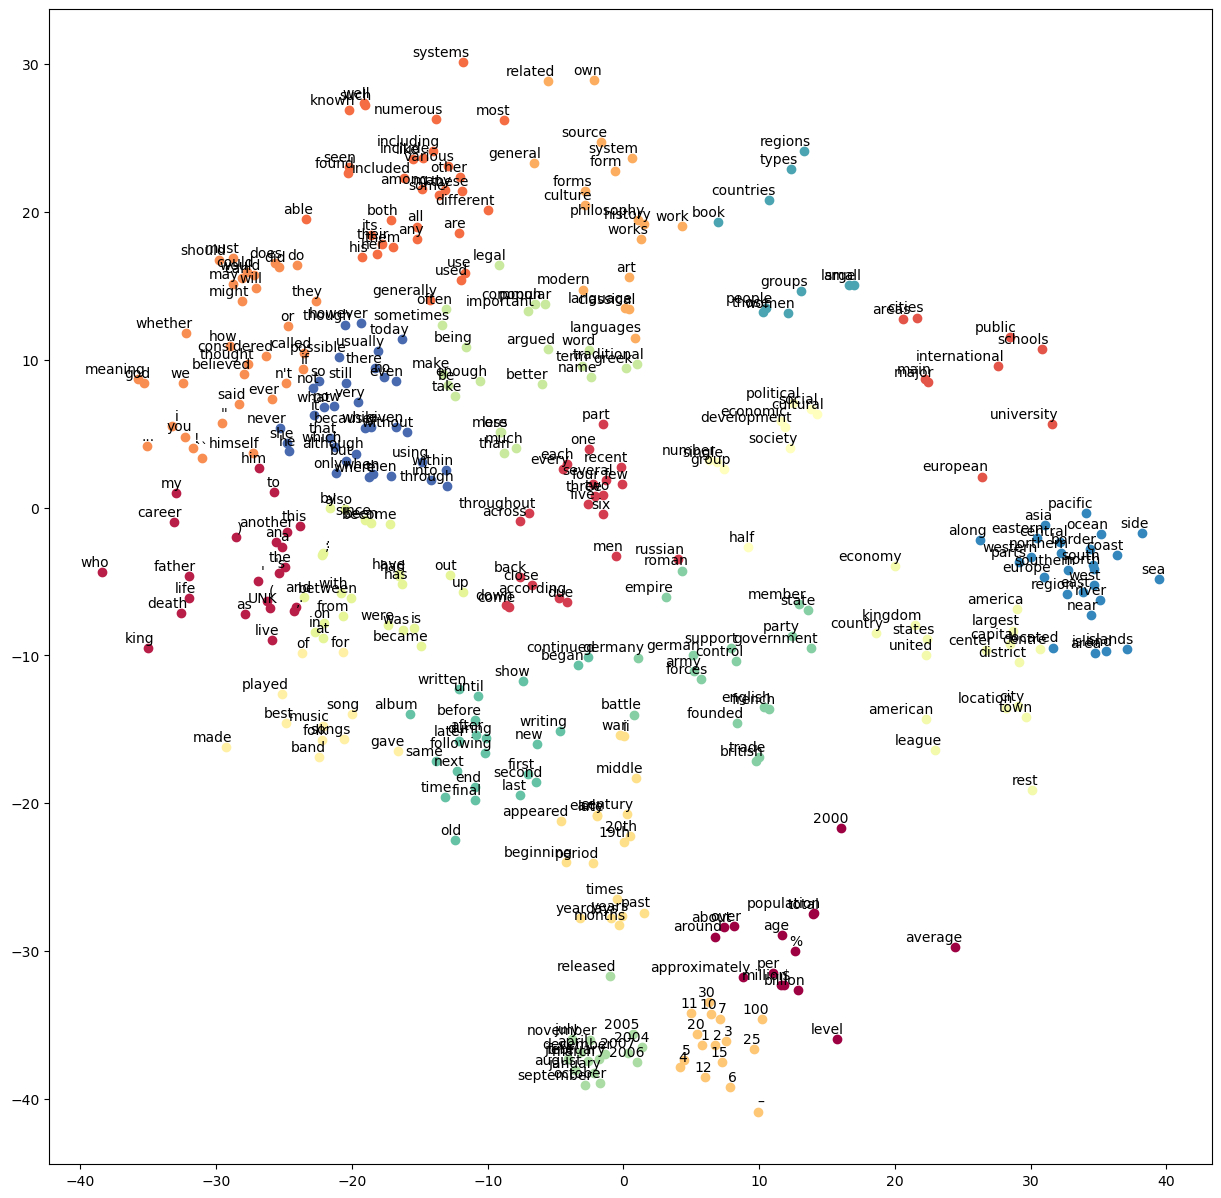

In [28]:
def plot(embeddings, labels):

    # Número de clusters
    n_clusters = 20

    # Constrói automaticamente um conjunto discreto de cores, cada uma para o cluster
    cmap = pylab.cm.get_cmap("Spectral")
    label_colors = [cmap(float(i) /n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), 'Mais rótulos do que embeddings'

    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_

    pylab.figure(figsize=(15,15))

    # Plot de todos os embeddings e suas palavras correspondentes
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, c=label_colors[klabel])

        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',fontsize=10)

    # Usar para salvar a figura, se necessário
    # pylab.savefig('word_embeddings.png')
    pylab.show()

words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)

# Algoritmo CBOW 

Agora, partindo de uma janela arbitrária de tamanho C, vamos construir observações do tipo ([wI1 , . . . ,wIC ],wO). 

- Observação =>  ([wI1 , . . . ,wIC ], w0)
- Resultado => ([com, o, dessa, banda], cantor)

Repetindo esse processo com diferentes exemplos extraídos do corpus o efeito vai acumular e como resultado palavras com contexto similar vão ficar próximas entre si. O que o modelo faz é capturar as estatísticas de co-ocorrência usando a distância cosseno.

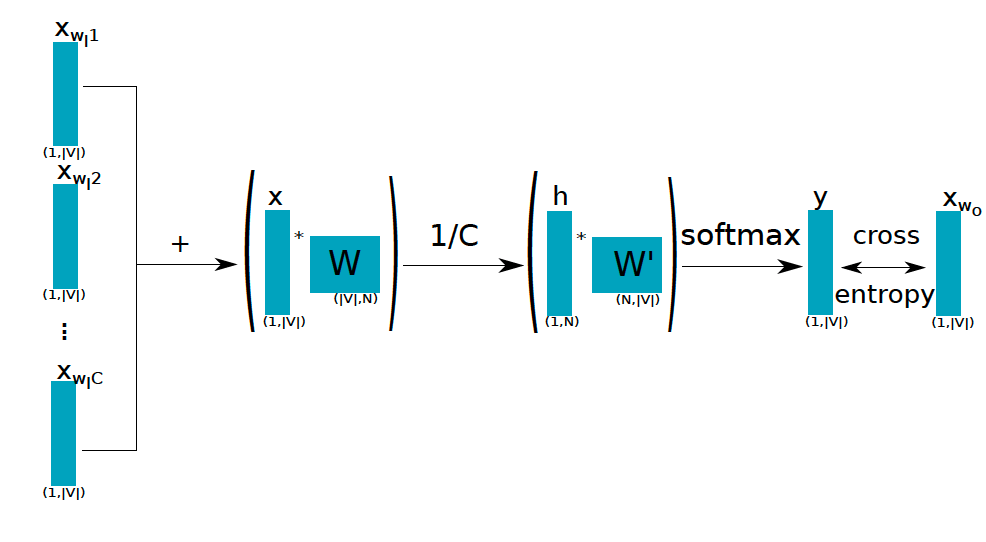

In [29]:
from IPython.display import Image
Image("images/cbow.png")

## Alterando o Processo de Geração de Dados
Precisamos definir um novo gerador de dados para o CBOW. A forma da nova matriz de entrada é (batch_size, context_window * 2). Ou seja, um lote no CBOW captura todas as palavras no contexto de uma determinada palavra.

In [30]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):
    # window_size é a quantidade de palavras que estamos vendo de cada lado de uma determinada palavra

    # data_index é atualizado por 1 toda vez que lemos um conjunto de dados
    global data_index

    # span define o tamanho total da janela, onde
    # dados que consideramos em uma instância são exibidos da seguinte maneira.
    # [skip_window target skip_window]
    # por exemplo, se skip_window = 2, em seguida, span = 5
    span = 2 * window_size + 1 # [ skip_window target skip_window ]

    # Dois arrays numpy para manter as palavras-alvo (lote)
    # e palavras de contexto (rótulos)
    # Observe que o lote tem colunas span-1 = 2 * window_size
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    # O buffer contém os dados contidos no intervalo
    buffer = collections.deque(maxlen=span)

    # Preenche o buffer e atualize o data_index
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # Aqui nós fazemos a leitura do lote
    # Nós iteramos através de cada índice de lote
    # Para cada índice de lote, iteramos pelos elementos de intervalo
    # para preencher as colunas da matriz de lotes
    for i in range(batch_size):

        # rótulo de destino no centro do buffer
        target = window_size

        # Só precisamos saber as palavras em torno de uma determinada palavra, não a palavra em si
        target_to_avoid = [ window_size ]

        # Adiciona o alvo selecionado para avoid_list da próxima vez
        col_idx = 0
        for j in range(span):

            # Ignora a palavra alvo ao criar o lote
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j]
            col_idx += 1
        labels[i, 0] = buffer[target]

        # Toda vez que lemos um ponto de dados,
        # precisamos mover o span por 1
        # para criar um novo intervalo
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nCom window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


Com window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'concerted'], ['a', 'set'], ['concerted', 'of'], ['set', 'messages'], ['of', 'aimed'], ['messages', 'at'], ['aimed', 'influencing']]
    labels: ['is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at']

Com window_size = 2:
    batch: [['propaganda', 'is', 'concerted', 'set'], ['is', 'a', 'set', 'of'], ['a', 'concerted', 'of', 'messages'], ['concerted', 'set', 'messages', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'messages', 'at', 'influencing'], ['messages', 'aimed', 'influencing', 'the'], ['aimed', 'at', 'the', 'opinions']]
    labels: ['a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']


### Definindo os Hiperparâmetros

Aqui nós definimos vários hiperparâmetros incluindo:

- `batch_size` (quantidade de amostras em um único lote)
- `embedding_size` (tamanho dos vetores embedding) 
- `window_size` (tamanho da janela de contexto).

In [31]:
# Pontos de dados em um único lote
batch_size = 128

# Dimensão do embedding vector.
embedding_size = 128

# Quantas palavras considerar à esquerda e à direita.
window_size = 2

# Nós escolhemos um conjunto de validação aleatório para testar os vizinhos mais próximos
# Conjunto aleatório de palavras para avaliar a similaridade.
valid_size = 16

# Nós experimentamos datapoints válidos aleatoriamente a partir de uma janela grande sem sermos sempre determinísticos
valid_window = 50

# Ao selecionar exemplos válidos, selecionamos algumas das palavras mais frequentes,
# bem como algumas palavras moderadamente raras
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)

# Número de exemplos negativos para amostra.
num_sampled = 32

### Definindo Entradas e Saídas

Aqui nós definimos espaços reservados (placeholders) para alimentação dos dados de entrada e saída no treinamento (cada um dos tamanhos `batch_size`) e um tensor constante para conter exemplos de validação.

In [32]:
tf.compat.v1.reset_default_graph()

# Dados de entrada de treinamento (IDs de palavras de destino).
train_dataset = tf.compat.v1.placeholder(tf.int32, shape=[batch_size,2*window_size])

# Dados de etiqueta de entrada de treinamento (IDs de palavras de contexto)
train_labels = tf.compat.v1.placeholder(tf.int32, shape=[batch_size, 1])

# Dados de entrada de validação, não precisamos de um espaço reservado,
# pois já definimos os IDs das palavras selecionadas como dados de validação
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Definindo Parâmetros do Modelo e Outras Variáveis
Nós agora definimos várias variáveis do TensorFlow, como uma camada embeddings (`embeddings`) e parâmetros de rede neural (`softmax_weights` e `softmax_biases`)

In [33]:
# Variáveis

# Embedding layer, contém as word embeddings
embeddings = tf.Variable(tf.random.uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))

# Softmax Weights e Biases
softmax_weights = tf.Variable(tf.random.truncated_normal([vocabulary_size, embedding_size],
                 stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))

softmax_biases = tf.Variable(tf.random.uniform([vocabulary_size],0.0,0.01))

### Definindo as Computações do Modelo

Primeiro, definimos uma função de pesquisa para buscar os vetores embedding correspondentes para um conjunto de entradas fornecidas. Concretamente, definimos pesquisas embedding de 2 $ x $ `window_size`. Em seguida, concatenamos todos esses vetores pesquisados para formar uma matriz de tamanho `[batch_size, embedding_size, 2 * window_size]`. Posteriormente, calculamos a média dessas pesquisas embedding para produzir um embedding médio de tamanho `[batch_size, embedding_size]`. Com isso, definimos a função de perda negativa de amostragem `tf.nn.sampled_softmax_loss` que inclui os vetores embedding e os parâmetros de rede neural previamente definidos.

In [34]:
# Modelo

# Aqui fazemos pesquisas de embedings para cada coluna no espaço reservado de entrada
# e, em seguida, calculamos a média para produzir um vetor de palavra embedding_size
stacked_embedings = None
print('Definindo %d embedding de pesquisas representando cada palavra no contexto'%(2*window_size))

for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(params=embeddings, ids=train_dataset[:,i])
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())

mean_embeddings =  tf.reduce_mean(input_tensor=stacked_embedings,axis=2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Calcula a perda do softmax usando uma amostra dos rótulos negativos de cada vez.
# entradas são embeddings das palavras do dataset de treino
# Com essa perda, otimizamos pesos, vieses, embeddings
loss = tf.reduce_mean(
    input_tensor=tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

Definindo 4 embedding de pesquisas representando cada palavra no contexto
Stacked embedding size: [128, 128, 4]
Reduced mean embedding size: [128, 128]


### Otimizador

Em seguida, definimos uma taxa de aprendizado como uma constante e um otimizador que usa o método Adagrad. Sinta-se à vontade para experimentar outros otimizadores listados [aqui] (https://www.tensorflow.org/api_guides/python/train).

In [35]:
# Otimizador
optimizer = tf.compat.v1.train.AdagradOptimizer(1.0).minimize(loss)

### Calculando similaridades de palavras
Calculamos a similaridade entre duas palavras dadas em termos da distância do cosseno. Para fazer isso de maneira eficiente, usamos operações de matriz para fazer isso, conforme mostrado abaixo.

In [36]:
# Calcula a similaridade entre os exemplos de minibatch e todos os embeddings.
# Nós usamos a distância do cosseno:
norm = tf.sqrt(tf.reduce_sum(input_tensor=tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(params=normalized_embeddings, ids=valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(a=normalized_embeddings))

## Treinando o Algoritmo CBOW 

In [37]:
num_steps = 100001
cbow_losses = []

# ConfigProto é uma maneira de fornecer várias configurações necessárias para executar o grafo
with tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True)) as session:

    # Inicializa as variáveis no grafo
    tf.compat.v1.global_variables_initializer().run()
    print('Variáveis Inicializadas')

    average_loss = 0

    # Treina o modelo Word2vec para iterações num_step
    for step in range(num_steps):

        # Gera um único lote de dados
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)

        # Preenche o feed_dict, executa o otimizador (minimize loss) e calcule a perda
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        # Atualiza a variável de perda média
        average_loss += l

        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            cbow_losses.append(average_loss)
            print('Erro Médio no Passo %d: %f' % (step+1, average_loss))
            average_loss = 0

        # Avaliação de simlaridade de palavras do conjunto de validação
        if (step+1) % 10000 == 0:
            sim = similarity.eval()
            # Aqui nós calculamos as palavras top_k mais próximas para uma dada palavra de validação
            # em termos da distância cosseno. Fazemos isso para todas as palavras no conjunto de validação.
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Mais Próximo da palavra %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()


np.save('resultado/cbow_embeddings', cbow_final_embeddings)

with open('resultado/cbow_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_losses)

2023-04-04 11:27:14.170799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:27:14.171008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:27:14.171066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:27:14.171439: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-04 11:27:14.171471: I tensorflow/core/co

Variáveis Inicializadas
Erro Médio no Passo 2000: 3.583050
Erro Médio no Passo 4000: 3.069462
Erro Médio no Passo 6000: 2.948388
Erro Médio no Passo 8000: 2.864023
Erro Médio no Passo 10000: 2.803390
Mais Próximo da palavra city: improvements, world, aim, multilateral, na+/k+/atpase, berne, flack, ki,
Mais Próximo da palavra be: have, disliking, is, caesarean, are, were, crystallize, hibernating,
Mais Próximo da palavra in: cplp, emetic, attract, during, dhimmis, stellar, tenor, spits,
Mais Próximo da palavra and: or, but, mamluk, polynésie, stipules, viljoen, rounders, heldman,
Mais Próximo da palavra .: ;, :, ,, stamped, morant, niche, tube, colbert,
Mais Próximo da palavra has: have, had, is, structuralist, linus, comets, superposition, pasture,
Mais Próximo da palavra were: are, was, kundakunda, 1808., had, be, irresistible, unwilling,
Mais Próximo da palavra as: too, south-western, raubal, conflicts, kindreds, mcmurdo, ken, flows,
Mais Próximo da palavra ``: latest, neman, right-w

Erro Médio no Passo 52000: 2.325412
Erro Médio no Passo 54000: 2.285788
Erro Médio no Passo 56000: 2.253107
Erro Médio no Passo 58000: 2.243648
Erro Médio no Passo 60000: 2.235997
Mais Próximo da palavra city: country, improvements, multilateral, berne, area, counter-offensive, dhulbahante, adventurism,
Mais Próximo da palavra be: being, been, have, tatra, are, 1921., is, remain,
Mais Próximo da palavra in: until, during, since, throughout, cplp, stellar, emetic, tenor,
Mais Próximo da palavra and: or, but, polynésie, stipules, while, steuart, hydrocarbons, mamluk,
Mais Próximo da palavra .: ;, morant, ,, :, stamped, 2005., concerning, .the,
Mais Próximo da palavra has: have, had, is, having, structuralist, 619,636, t1, holds,
Mais Próximo da palavra were: are, was, kundakunda, russo-turkish, appearing, been, undershoot, emi,
Mais Próximo da palavra as: on-going, too, ken, raubal, beowulf, bearing, hector, forthcoming,
Mais Próximo da palavra ``: latest, floyd, humiliate, desirous, int

# Fim